# ML for Bioinformatics
## Variational Autoencoder

---

Name: Sana Ayromlou

---


#import library and setting device

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import MSELoss
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm, trange
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
######################## P0 ########################## 
# check if gpu is available then put device to cuda0 #
# else device is equal to cpu                        #
######################################################

######################## end #########################

cuda:0


#loading Data
The MNIST database of handwritten digits contain diffrents images of digits. 

similar to MNIST,fashionMNIST is dataset containg 10 type of clothes instead of 10 type of digits. 

for example label 0 in MNIST is for 0 digit and 0 in FashionMNIST is for T-shirt. all the images is gray-scale and 28*28.

for more information you can visit this [link](https://github.com/zalandoresearch/fashion-mnist) 

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)])

In [4]:
import torchvision
# Get MNIST dataloader
BATCH_SIZE = 128
data_loader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}
train_dataset = torchvision.datasets.FashionMNIST('./data/FashionMNIST', train=True, transform=transform, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST('./data/FashionMNIST', train=False, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
############################## P1 ##############################
# in this cell first download the fashionMNIST dataset         #
# for train (use toTensor transform and download = True)       #
# and put it in train_dataset. then get test dataset          #
# and put it in test_dataset(no need to download again).       #
# then make train and test loader using the data_loader_kwargs #
################################################################

######################## end #########################


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)



torch.Size([64, 1, 28, 28])
torch.Size([64])


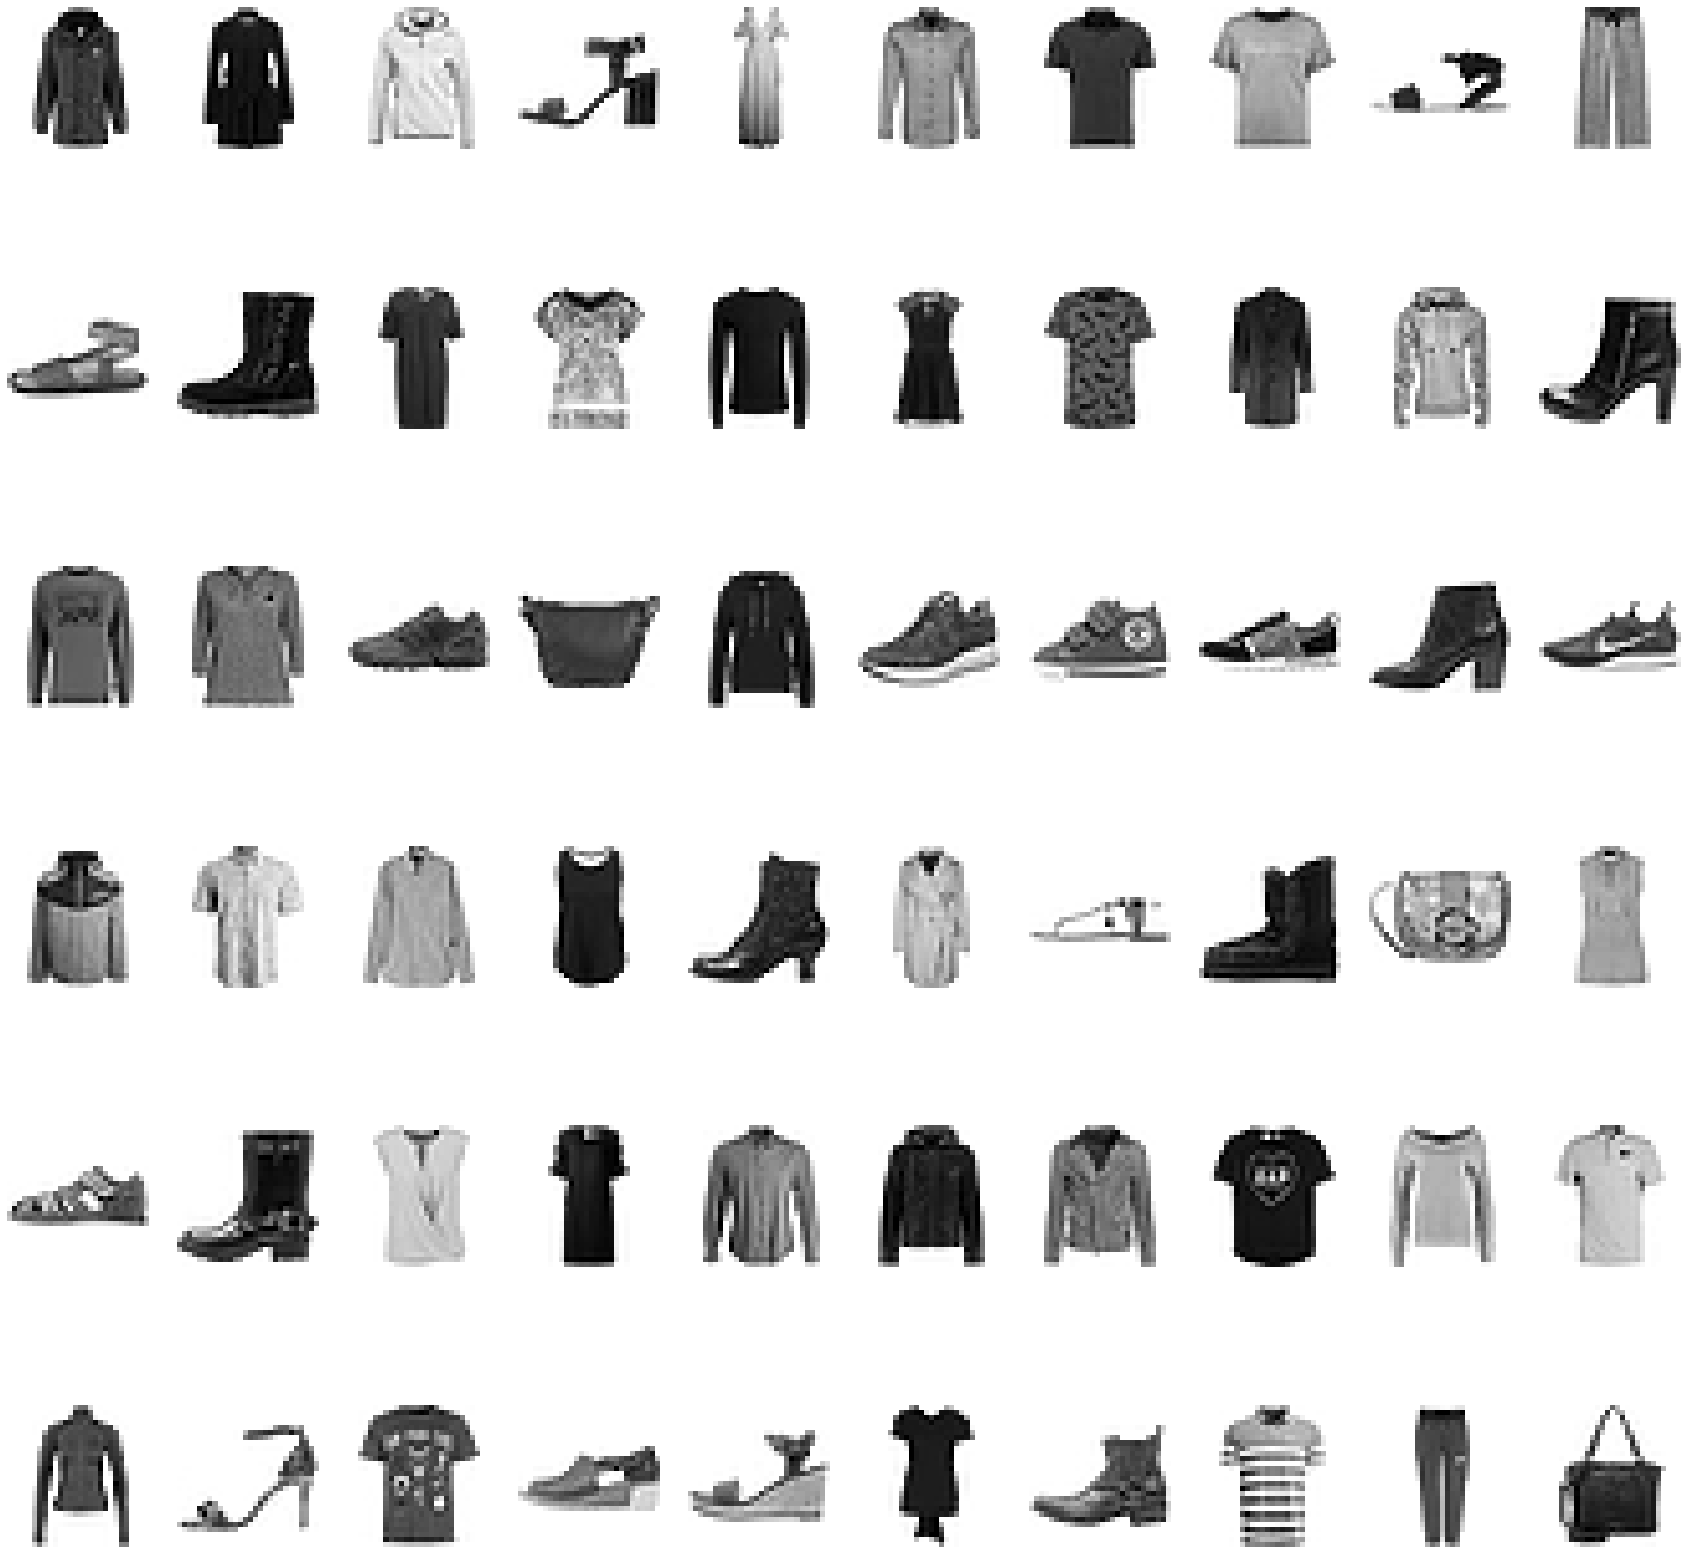

In [6]:
figure = plt.figure(figsize=(30, 30))
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#Auto-Encoder

In [11]:
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()
        # input_dim = is the dimension of your input
        # encoder_dims = is list containing of some integer that shows the dimension of encoder layers, between input layer and latent layer  
        # z_dim = dimension of latent layer
        # decoder_dims = is list containing of some integer that shows the dimension of decoder layers, between latent layer and output layer (same as input_dim)  
        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)
        encoder_layers = list()
        ####################### P2 ###############################
        # Iterate over `encoder_dims` and create fully connected #
        # layers using nn.Linear. Use ReLU activation function   #   
        # after each FC layer using nn.ReLU Append all layers to #
        #`encoder_layers`.                                       #
        ##########################################################
        for i in range(len(encoder_dims)):
            if i == 0:
                encoder_layers.append(nn.Linear(input_dim, encoder_dims[i]))
            else:
                encoder_layers.append(nn.Linear(encoder_dims[i-1], encoder_dims[i]))
            if i != len(encoder_dims)-1:
                encoder_layers.append(nn.ReLU(inplace=True))
        ####################### End ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Compute Z
        self.z_layer = None
        ########################  P3 #############################
        # Define a fully connected layer that maps the output of #
        # previous part to `z_dim` dimensions, store it in       #
        # `self.z_layer`. No activation function is needed after #
        # this layer.                                            #
        ##########################################################
        self.z_layer = nn.Linear(encoder_dims[-1],z_dim)
        ######################## End #############################
        # Decoder part
        decoder_layers = list()
        ########################## P4 ###############################
        # Define the decoder part (Use `decoder_dims`)              #
        # Use ReLU activation function after each FC layer          # 
        # (except the last one).The last layer output should be     #
        # of `input_dim` size. Append all layers to `decoder_layers`#
        #############################################################
        for i in range(len(decoder_dims)):
            if i == 0:
                decoder_layers.append(nn.Linear(z_dim, decoder_dims[i]))
            else:
                decoder_layers.append(nn.Linear(decoder_dims[i-1], decoder_dims[i]))
            decoder_layers.append(nn.ReLU(inplace=True))
        decoder_layers.append(nn.Linear(decoder_dims[i], input_dim))
        ####################### End ##################################
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)
        ################ P5 #######################
        # Do the forward pass                     #
        # use dropped_out instead of x            #
        # Compute `x_hat` (reconstructed inputs), #
        # and `z` (the latent variables)          #
        ###########################################
        dropped_out = self.encoder(dropped_out)
        z = self.z_layer(dropped_out)
        x_hat = self.decoder(z)
        ####################### End ###############
        return x_hat, z, None 

    def get_loss(self, x, x_hat, *_):
        ########### P6 ############
        # Compute and return the  #
        # MSE between x and x_hat #
        ###########################
 
        loss = MSELoss()
        return loss(x,x_hat)
        ########### End ###########

# train and test functions
in the following cells we enumerate on datasets and on each batch, first we flatten 28*28 image to 784 and then giving this to forward pass of our model. then by computing loss and running backprop on loss we can have all the gradients. then by calling optimizer.step() we update all the parameters.
in test function we find loss and report that.


In [7]:
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
LOG_INTERVAL = 200
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    
    model.train()
    train_loss = 0
    for param_group in optimizer.param_groups:
         print("LR", param_group['lr'])
    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)

        loss = model.get_loss(x, x_hat, mu, logvar)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))
    #scheduler.step(loss)
    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [8]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)
            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [9]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """
    LEARNING_RATE = 5e-5
    ###################### P7 ################################
    # Send `model` to the desired device, defined in `device`#
    ##########################################################
    print("here")
    model.to(device)
    print("here2")
    ####################### End ##############################

    optimizer = None
    ################## P8 #####################
    # Initialize a new Adam optimizer         #
    ###########################################
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

    #lr_scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=2, verbose=True)    
    ################## End ####################

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer ,verbose)
        test(model, verbose)

In [ ]:
#run this cell to train model and report loss on test dataset
ae = AE(28*28, [512,128,64], 10, [64,128,512])
print(ae.children)
run(ae,40)

<bound method Module.children of AE(
  (dropout): Dropout(p=0.2, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (z_layer): Linear(in_features=64, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)>
here
here2



Epoch 1:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00114
    Train [25536/60000]	 | 	Loss: 0.00070
    Train [38336/60000]	 | 	Loss: 0.00057
    Train [51136/60000]	 | 	Loss: 0.00061
==> Train | Average loss: 0.0009
==> Test  | Average loss: 0.0005

Epoch 2:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00048
    Train [25536/60000]	 | 	Loss: 0.00046
    Train [38336/60000]	 | 	Loss: 0.00045
    Train [51136/60000]	 | 	Loss: 0.00039
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0004

Epoch 3:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00042
    Train [25536/60000]	 | 	Loss: 0.00035
    Train [38336/60000]	 | 	Loss: 0.00039
    Train [51136/60000]	 | 	Loss: 0.00039
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 4:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00036
    Train [25536/60000]	 | 	Loss: 0.00038
    Train [38336/60000]	 | 	Loss: 0.00033
    Train [51136/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0003

Epoch 5:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00037
    Train [25536/60000]	 | 	Loss: 0.00038
    Train [38336/60000]	 | 	Loss: 0.00039
    Train [51136/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 6:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00034
    Train [25536/60000]	 | 	Loss: 0.00033
    Train [38336/60000]	 | 	Loss: 0.00033
    Train [51136/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 7:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00034
    Train [25536/60000]	 | 	Loss: 0.00032
    Train [38336/60000]	 | 	Loss: 0.00030
    Train [51136/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 8:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00030
    Train [25536/60000]	 | 	Loss: 0.00030
    Train [38336/60000]	 | 	Loss: 0.00033
    Train [51136/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 9:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00033
    Train [25536/60000]	 | 	Loss: 0.00030
    Train [38336/60000]	 | 	Loss: 0.00030
    Train [51136/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 10:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00033
    Train [25536/60000]	 | 	Loss: 0.00028
    Train [38336/60000]	 | 	Loss: 0.00030
    Train [51136/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 11:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00028
    Train [25536/60000]	 | 	Loss: 0.00027
    Train [38336/60000]	 | 	Loss: 0.00030
    Train [51136/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 12:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00028
    Train [25536/60000]	 | 	Loss: 0.00035
    Train [38336/60000]	 | 	Loss: 0.00027
    Train [51136/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 13:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00030
    Train [25536/60000]	 | 	Loss: 0.00025
    Train [38336/60000]	 | 	Loss: 0.00030
    Train [51136/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 14:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00031
    Train [25536/60000]	 | 	Loss: 0.00026
    Train [38336/60000]	 | 	Loss: 0.00026
    Train [51136/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 15:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00026
    Train [25536/60000]	 | 	Loss: 0.00026
    Train [38336/60000]	 | 	Loss: 0.00027
    Train [51136/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 16:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00030
    Train [25536/60000]	 | 	Loss: 0.00025
    Train [38336/60000]	 | 	Loss: 0.00028
    Train [51136/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 17:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00029
    Train [25536/60000]	 | 	Loss: 0.00024
    Train [38336/60000]	 | 	Loss: 0.00025
    Train [51136/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 18:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00026
    Train [25536/60000]	 | 	Loss: 0.00032
    Train [38336/60000]	 | 	Loss: 0.00028
    Train [51136/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 19:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00024
    Train [25536/60000]	 | 	Loss: 0.00025
    Train [38336/60000]	 | 	Loss: 0.00031
    Train [51136/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 20:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00025
    Train [25536/60000]	 | 	Loss: 0.00025
    Train [38336/60000]	 | 	Loss: 0.00025
    Train [51136/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 21:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00029
    Train [25536/60000]	 | 	Loss: 0.00026
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 22:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00027
    Train [25536/60000]	 | 	Loss: 0.00026
    Train [38336/60000]	 | 	Loss: 0.00027
    Train [51136/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 23:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00024
    Train [25536/60000]	 | 	Loss: 0.00028
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00024
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 24:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00025
    Train [25536/60000]	 | 	Loss: 0.00023
    Train [38336/60000]	 | 	Loss: 0.00026
    Train [51136/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 25:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00028
    Train [25536/60000]	 | 	Loss: 0.00030
    Train [38336/60000]	 | 	Loss: 0.00026
    Train [51136/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 26:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00029
    Train [25536/60000]	 | 	Loss: 0.00024
    Train [38336/60000]	 | 	Loss: 0.00025
    Train [51136/60000]	 | 	Loss: 0.00025
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 27:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00025
    Train [25536/60000]	 | 	Loss: 0.00023
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 28:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00025
    Train [25536/60000]	 | 	Loss: 0.00024
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 29:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00025
    Train [25536/60000]	 | 	Loss: 0.00023
    Train [38336/60000]	 | 	Loss: 0.00025
    Train [51136/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 30:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00031
    Train [25536/60000]	 | 	Loss: 0.00024
    Train [38336/60000]	 | 	Loss: 0.00028
    Train [51136/60000]	 | 	Loss: 0.00025
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 31:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00024
    Train [25536/60000]	 | 	Loss: 0.00026
    Train [38336/60000]	 | 	Loss: 0.00026
    Train [51136/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 32:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00026
    Train [25536/60000]	 | 	Loss: 0.00024
    Train [38336/60000]	 | 	Loss: 0.00028
    Train [51136/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 33:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00025
    Train [25536/60000]	 | 	Loss: 0.00027
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 34:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00027
    Train [25536/60000]	 | 	Loss: 0.00022
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00024
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 35:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00025
    Train [25536/60000]	 | 	Loss: 0.00023
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00021
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 36:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00023
    Train [25536/60000]	 | 	Loss: 0.00025
    Train [38336/60000]	 | 	Loss: 0.00023
    Train [51136/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 37:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00023
    Train [25536/60000]	 | 	Loss: 0.00021
    Train [38336/60000]	 | 	Loss: 0.00025
    Train [51136/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 38:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00026
    Train [25536/60000]	 | 	Loss: 0.00022
    Train [38336/60000]	 | 	Loss: 0.00028
    Train [51136/60000]	 | 	Loss: 0.00024
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 39:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00020
    Train [25536/60000]	 | 	Loss: 0.00028
    Train [38336/60000]	 | 	Loss: 0.00025
    Train [51136/60000]	 | 	Loss: 0.00023
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 40:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 0.00023
    Train [25536/60000]	 | 	Loss: 0.00024
    Train [38336/60000]	 | 	Loss: 0.00024
    Train [51136/60000]	 | 	Loss: 0.00025
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002



#VAE
now similar to auto encoder we want to make class that inherit from AE class and implement VAE

In [12]:
from torch.nn import init 
def init_weights(m):
    if type(m) == nn.Linear:
        init.kaiming_normal_(m.weight, mode='fan_in')
        m.bias.data.fill_(0.01)

class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)
        
        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore

        # Drouput, Encoder, and Decoder have been defined in AE class

        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None
        ############################# P10 #############################
        # Define mu and logvar layers                                 #
        # Notice that we should have a logvar_layer, not a sigma_layer#
        # Do not use any activation function                          #
        ###############################################################
        self.mu_layer = nn.Linear(encoder_dims[-1], z_dim)
        self.logvar_layer = nn.Linear(encoder_dims[-1], z_dim)
        ############################## End ############################
        self.mu_layer.apply(init_weights);
        self.logvar_layer.apply(init_weights);
        self.decoder.apply(init_weights);
        self.encoder.apply(init_weights);

    def reparameterize(self,mu, logvar):
        z = None
        ############################### P11 #################################
        # Sample `z` from N(`mu`, e^`logvar`) in a way that the gradient can#
        # backpropagate through this sampling operation                     #
        #####################################################################
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            z = eps.mul(std).add_(mu)
        else:
            z = mu
        ############################### End ##################################
        return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)
        ################################# P12 ####################################
        # Do the forward pass                                                    #
        # Compute `x_hat` (reconstructed inputs), `mu`, and `logvar` (outputs of #
        # `mu_layer` and `logvar_layer` respectively)                            #
        # Use reparameterization trick (the function you have implemented)       #
        ##########################################################################
        h = self.encoder(dropped_out)
        mu =  self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        ################################### End ###################################
        return x_hat, mu, logvar
    
    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0
        ################################## P13 ######################################
        # Compute the VAE loss (Assuming Guassian distribution for the decoder      #
        # output)                                                                   #
        #############################################################################
        #print(x_hat.shape,x.shape)
        #MSE = F.binary_cross_entropy(x_hat,x, reduction='sum')
        loss = MSELoss(reduction='sum')
        MSE = loss(x,x_hat)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        ################################## End ######################################
        return MSE + KLD

    def generate(self, n):
        samples = None
        ################################## P14 ##################################
        # Generate `n` random noises from N(0, I), feed it into the decoder and #
        # generate `n` samples                                                  #
        #########################################################################
        z = torch.randn(n, self.z_dim)

        z = z.to(device)

        samples = self.decoder(z)
        ################################### End #################################
        return samples

In [13]:
UDA_LAUNCH_BLOCKING=1

#Training VAE
using the functions from last part we can train our VAE model and see the loss on train and test datasets

In [14]:
vae = VAE(28*28, [512,128,64], 30, [64,128,512])
print(vae.children)
run(vae,40)

<bound method Module.children of VAE(
  (dropout): Dropout(p=0.2, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
  (mu_layer): Linear(in_features=64, out_features=30, bias=True)
  (logvar_layer): Linear(in_features=64, out_features=30, bias=True)
)>
here
here2



Epoch 1:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 370.25894
    Train [25536/60000]	 | 	Loss: 197.12219
    Train [38336/60000]	 | 	Loss: 153.31503
    Train [51136/60000]	 | 	Loss: 126.11871
==> Train | Average loss: 348.8692
==> Test  | Average loss: 85.7182

Epoch 2:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 108.10216
    Train [25536/60000]	 | 	Loss: 105.23329
    Train [38336/60000]	 | 	Loss: 93.93623
    Train [51136/60000]	 | 	Loss: 86.69402
==> Train | Average loss: 98.7319
==> Test  | Average loss: 63.5957

Epoch 3:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 79.23500
    Train [25536/60000]	 | 	Loss: 74.16302
    Train [38336/60000]	 | 	Loss: 78.10024
    Train [51136/60000]	 | 	Loss: 75.56620
==> Train | Average loss: 77.4090
==> Test  | Average loss: 55.6021

Epoch 4:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 69.42371
    Train [25536/60000]	 | 	Loss: 66.64334
    Train [38336/60000]	 | 	Loss: 64.91180
    Train [51136/60000]	 | 	Loss: 65.93594
==> Train | Average loss: 68.6473
==> Test  | Average loss: 50.5620

Epoch 5:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 67.22881
    Train [25536/60000]	 | 	Loss: 63.92429
    Train [38336/60000]	 | 	Loss: 61.73996
    Train [51136/60000]	 | 	Loss: 62.10854
==> Train | Average loss: 62.2294
==> Test  | Average loss: 46.1100

Epoch 6:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 58.99795
    Train [25536/60000]	 | 	Loss: 54.27628
    Train [38336/60000]	 | 	Loss: 55.00138
    Train [51136/60000]	 | 	Loss: 58.91747
==> Train | Average loss: 56.7569
==> Test  | Average loss: 42.3601

Epoch 7:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 49.88164
    Train [25536/60000]	 | 	Loss: 48.59357
    Train [38336/60000]	 | 	Loss: 52.15277
    Train [51136/60000]	 | 	Loss: 48.59931
==> Train | Average loss: 52.3119
==> Test  | Average loss: 39.7132

Epoch 8:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 49.05265
    Train [25536/60000]	 | 	Loss: 48.40192
    Train [38336/60000]	 | 	Loss: 48.69045
    Train [51136/60000]	 | 	Loss: 45.12104
==> Train | Average loss: 48.7514
==> Test  | Average loss: 37.2030

Epoch 9:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 48.56609
    Train [25536/60000]	 | 	Loss: 46.83935
    Train [38336/60000]	 | 	Loss: 47.08504
    Train [51136/60000]	 | 	Loss: 43.16684
==> Train | Average loss: 45.6961
==> Test  | Average loss: 35.0708

Epoch 10:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 42.42324
    Train [25536/60000]	 | 	Loss: 45.47496
    Train [38336/60000]	 | 	Loss: 43.33430
    Train [51136/60000]	 | 	Loss: 43.28968
==> Train | Average loss: 43.0275
==> Test  | Average loss: 33.4152

Epoch 11:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 41.00423
    Train [25536/60000]	 | 	Loss: 42.63892
    Train [38336/60000]	 | 	Loss: 39.16610
    Train [51136/60000]	 | 	Loss: 36.92399
==> Train | Average loss: 40.6611
==> Test  | Average loss: 31.7763

Epoch 12:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 39.16116
    Train [25536/60000]	 | 	Loss: 37.76479
    Train [38336/60000]	 | 	Loss: 37.84947
    Train [51136/60000]	 | 	Loss: 39.87567
==> Train | Average loss: 38.7928
==> Test  | Average loss: 30.8738

Epoch 13:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 37.39995
    Train [25536/60000]	 | 	Loss: 37.66922
    Train [38336/60000]	 | 	Loss: 33.00610
    Train [51136/60000]	 | 	Loss: 42.02393
==> Train | Average loss: 37.1465
==> Test  | Average loss: 29.9398

Epoch 14:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 37.37994
    Train [25536/60000]	 | 	Loss: 34.04225
    Train [38336/60000]	 | 	Loss: 39.82807
    Train [51136/60000]	 | 	Loss: 36.83115
==> Train | Average loss: 35.8569
==> Test  | Average loss: 29.2268

Epoch 15:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 32.92607
    Train [25536/60000]	 | 	Loss: 29.85952
    Train [38336/60000]	 | 	Loss: 36.41309
    Train [51136/60000]	 | 	Loss: 36.34153
==> Train | Average loss: 34.7256
==> Test  | Average loss: 28.7100

Epoch 16:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 33.99323
    Train [25536/60000]	 | 	Loss: 34.54915
    Train [38336/60000]	 | 	Loss: 32.30380
    Train [51136/60000]	 | 	Loss: 35.35865
==> Train | Average loss: 33.8537
==> Test  | Average loss: 28.2440

Epoch 17:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 31.82536
    Train [25536/60000]	 | 	Loss: 32.02711
    Train [38336/60000]	 | 	Loss: 33.15490
    Train [51136/60000]	 | 	Loss: 35.39083
==> Train | Average loss: 33.0355
==> Test  | Average loss: 27.7065

Epoch 18:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 35.09861
    Train [25536/60000]	 | 	Loss: 31.24857
    Train [38336/60000]	 | 	Loss: 30.20340
    Train [51136/60000]	 | 	Loss: 30.29913
==> Train | Average loss: 32.4129
==> Test  | Average loss: 27.1717

Epoch 19:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 32.51775
    Train [25536/60000]	 | 	Loss: 31.50954
    Train [38336/60000]	 | 	Loss: 32.62619
    Train [51136/60000]	 | 	Loss: 34.41395
==> Train | Average loss: 31.7758
==> Test  | Average loss: 26.8664

Epoch 20:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 31.94563
    Train [25536/60000]	 | 	Loss: 31.63286
    Train [38336/60000]	 | 	Loss: 31.01091
    Train [51136/60000]	 | 	Loss: 31.69889
==> Train | Average loss: 31.2297
==> Test  | Average loss: 26.6371

Epoch 21:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 31.56197
    Train [25536/60000]	 | 	Loss: 32.79657
    Train [38336/60000]	 | 	Loss: 30.21308
    Train [51136/60000]	 | 	Loss: 33.04839
==> Train | Average loss: 30.7968
==> Test  | Average loss: 26.2310

Epoch 22:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 32.51334
    Train [25536/60000]	 | 	Loss: 30.46390
    Train [38336/60000]	 | 	Loss: 29.61017
    Train [51136/60000]	 | 	Loss: 29.31709
==> Train | Average loss: 30.3957
==> Test  | Average loss: 25.8470

Epoch 23:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 29.02399
    Train [25536/60000]	 | 	Loss: 31.68853
    Train [38336/60000]	 | 	Loss: 30.80360
    Train [51136/60000]	 | 	Loss: 30.94433
==> Train | Average loss: 30.0506
==> Test  | Average loss: 25.9176

Epoch 24:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 28.24890
    Train [25536/60000]	 | 	Loss: 28.86435
    Train [38336/60000]	 | 	Loss: 28.64212
    Train [51136/60000]	 | 	Loss: 31.60622
==> Train | Average loss: 29.6902
==> Test  | Average loss: 25.6765

Epoch 25:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 30.31101
    Train [25536/60000]	 | 	Loss: 26.88148
    Train [38336/60000]	 | 	Loss: 31.74534
    Train [51136/60000]	 | 	Loss: 28.23905
==> Train | Average loss: 29.4445
==> Test  | Average loss: 25.5193

Epoch 26:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 28.92723
    Train [25536/60000]	 | 	Loss: 28.26640
    Train [38336/60000]	 | 	Loss: 31.37173
    Train [51136/60000]	 | 	Loss: 28.15278
==> Train | Average loss: 29.1869
==> Test  | Average loss: 25.4652

Epoch 27:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 29.64762
    Train [25536/60000]	 | 	Loss: 27.74359
    Train [38336/60000]	 | 	Loss: 27.01285
    Train [51136/60000]	 | 	Loss: 30.44213
==> Train | Average loss: 28.9586
==> Test  | Average loss: 25.1949

Epoch 28:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 29.23126
    Train [25536/60000]	 | 	Loss: 29.35199
    Train [38336/60000]	 | 	Loss: 28.00322
    Train [51136/60000]	 | 	Loss: 30.91243
==> Train | Average loss: 28.7206
==> Test  | Average loss: 25.1902

Epoch 29:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 29.70386
    Train [25536/60000]	 | 	Loss: 30.21766
    Train [38336/60000]	 | 	Loss: 26.27118
    Train [51136/60000]	 | 	Loss: 29.94310
==> Train | Average loss: 28.5185
==> Test  | Average loss: 24.7770

Epoch 30:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 27.40252
    Train [25536/60000]	 | 	Loss: 28.17034
    Train [38336/60000]	 | 	Loss: 27.04952
    Train [51136/60000]	 | 	Loss: 28.91180
==> Train | Average loss: 28.3246
==> Test  | Average loss: 24.8096

Epoch 31:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 28.49808
    Train [25536/60000]	 | 	Loss: 27.09682
    Train [38336/60000]	 | 	Loss: 27.45004
    Train [51136/60000]	 | 	Loss: 27.45874
==> Train | Average loss: 28.1387
==> Test  | Average loss: 24.7319

Epoch 32:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 27.55700
    Train [25536/60000]	 | 	Loss: 25.53531
    Train [38336/60000]	 | 	Loss: 30.73983
    Train [51136/60000]	 | 	Loss: 29.35168
==> Train | Average loss: 27.9652
==> Test  | Average loss: 24.4883

Epoch 33:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 26.47437
    Train [25536/60000]	 | 	Loss: 28.02290
    Train [38336/60000]	 | 	Loss: 24.96063
    Train [51136/60000]	 | 	Loss: 28.44982
==> Train | Average loss: 27.7960
==> Test  | Average loss: 24.4992

Epoch 34:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 27.30822
    Train [25536/60000]	 | 	Loss: 28.15297
    Train [38336/60000]	 | 	Loss: 28.92405
    Train [51136/60000]	 | 	Loss: 27.02328
==> Train | Average loss: 27.6449
==> Test  | Average loss: 24.4117

Epoch 35:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 26.68615
    Train [25536/60000]	 | 	Loss: 29.01354
    Train [38336/60000]	 | 	Loss: 29.62445
    Train [51136/60000]	 | 	Loss: 27.21424
==> Train | Average loss: 27.4966
==> Test  | Average loss: 24.1204

Epoch 36:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 26.16693
    Train [25536/60000]	 | 	Loss: 29.33105
    Train [38336/60000]	 | 	Loss: 27.13876
    Train [51136/60000]	 | 	Loss: 27.71807
==> Train | Average loss: 27.3474
==> Test  | Average loss: 24.1471

Epoch 37:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 26.74981
    Train [25536/60000]	 | 	Loss: 28.92010
    Train [38336/60000]	 | 	Loss: 27.27740
    Train [51136/60000]	 | 	Loss: 26.00285
==> Train | Average loss: 27.2205
==> Test  | Average loss: 24.1414

Epoch 38:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 28.26312
    Train [25536/60000]	 | 	Loss: 25.29354
    Train [38336/60000]	 | 	Loss: 27.08467
    Train [51136/60000]	 | 	Loss: 25.85621
==> Train | Average loss: 27.1186
==> Test  | Average loss: 23.9682

Epoch 39:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 26.69059
    Train [25536/60000]	 | 	Loss: 26.73285
    Train [38336/60000]	 | 	Loss: 28.18047
    Train [51136/60000]	 | 	Loss: 27.53176
==> Train | Average loss: 26.9613
==> Test  | Average loss: 23.8336

Epoch 40:
LR 5e-05


    Train [12736/60000]	 | 	Loss: 25.93521
    Train [25536/60000]	 | 	Loss: 25.79076
    Train [38336/60000]	 | 	Loss: 29.22756
    Train [51136/60000]	 | 	Loss: 25.78984
==> Train | Average loss: 26.8570
==> Test  | Average loss: 23.7571



In [15]:
import math
def show(images, rows=1):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)
    print(images.shape)
    ########################### P9 #############################
    # calculate the #cols that we need and then plot images in #
    # appropriate #cols and #rows                              #
    ############################################################
    figure = plt.figure(figsize=(30, 30))
    for index in range(1, len(images) + 1):
        plt.subplot(rows, int(len(images)/rows)+1, index)
        plt.axis('off')
        plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
    ############################ end ###########################

Data
torch.Size([20, 28, 28])
torch.Size([20, 28, 28])
torch.Size([20, 784])
VAE 30D
torch.Size([20, 28, 28])


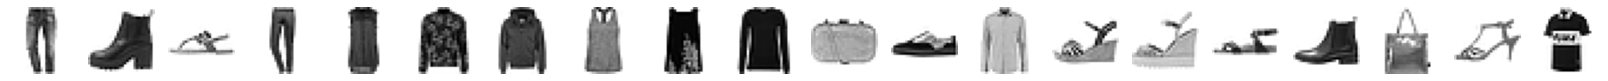

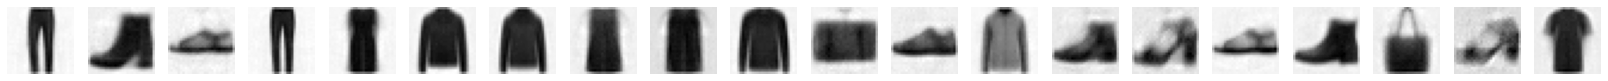

In [ ]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]  # Get a batch and choose `n` of images
    print('Data')
    print(x.squeeze(1).shape)
    show(x.squeeze(1))

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print(x_hat.shape)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu())
models = [vae]
plot_reconstructions(models, 20)

#interpolation part1
now we want to produce first image that has new features. there is probablity that these features even not exist in train dataset. in this part we want to find the mean of some trouser images in z space and then find mean of some shirt image in z space. then add this means together and give this new z to decoder. we expect that we have Tshirt that has trouser on it.
this is so usefull. consider some images of some faces. mean all the faces that has smile on theire faces and similar thing to all faces that has no smile. then subtract no smile mean in z space from smile faces in z-space. this work gives you the smile in z space. so you can add this smile to every face and make angry face to happy face !!

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!



Data
torch.Size([20, 28, 28])

Data
torch.Size([20, 28, 28])


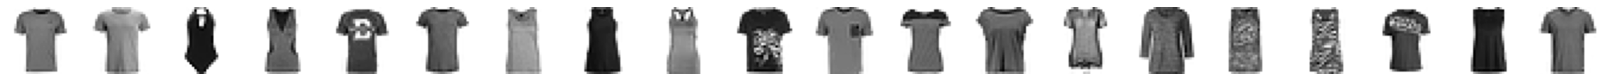

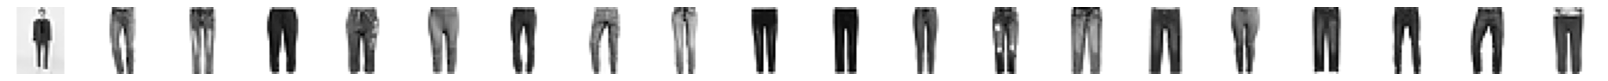

In [16]:
train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 0
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_trouser = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_trouser))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1))

train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 1
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_shirts = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_shirts))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1))

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 30])
torch.Size([30])
torch.Size([30])
torch.Size([30])


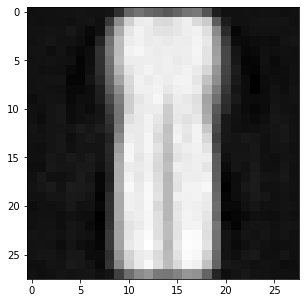

In [19]:
def combine(model, n_rows):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (5, 5)
    x = next(iter(test_loader_trouser))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    print(x.shape)
    y = next(iter(test_loader_shirts))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    print(x.shape)
    shirt_with_trouser = None
    ########################## P15 ###############################
    # use x , y and find mean of trousers and Tshirts in z space #
    # then add theme together in z space and store this value    #
    # in shirt_with_trouser                                      #
    ########################## end ###############################
    dropped_out = model.dropout(x)
    h = model.encoder(dropped_out)
    mu =  model.mu_layer(h)
    logvar = model.logvar_layer(h)
    trousers = model.reparameterize(mu, logvar)
    print(trousers.shape)
    t = sum(trousers)/len(trousers)
    print(t.shape)
    dropped_out = model.dropout(y)
    h = model.encoder(dropped_out)
    mu =  model.mu_layer(h)
    logvar = model.logvar_layer(h)
    Tshirts = model.reparameterize(mu, logvar)
    t2 = sum(Tshirts)/len(Tshirts)
    print(t2.shape)

    shirt_with_trouser = t + t2
    print(shirt_with_trouser.shape)
    ######################### end ##############################
    img = model.decoder(shirt_with_trouser).cpu().detach()
    img = img.reshape(-1, 28, 28)
    plt.imshow(img[0],cmap = "gray")
vae = vae.to(device)
combine(vae, 64)

#interpolations part 2


AE 10D
torch.Size([12, 28, 28])
AE 10D
torch.Size([12, 28, 28])
AE 10D
torch.Size([12, 28, 28])
---

VAE 30D
torch.Size([12, 28, 28])
VAE 30D
torch.Size([12, 28, 28])
VAE 30D
torch.Size([12, 28, 28])
---



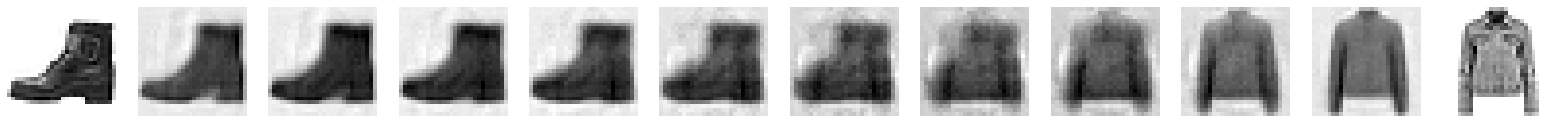

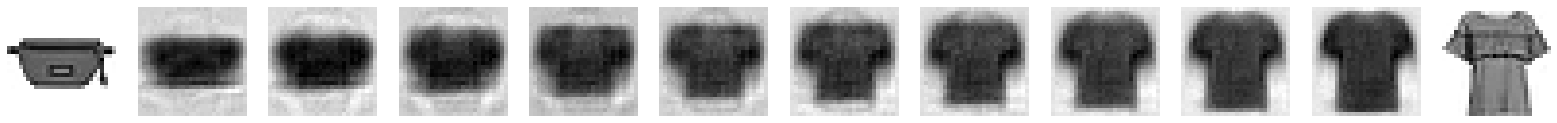

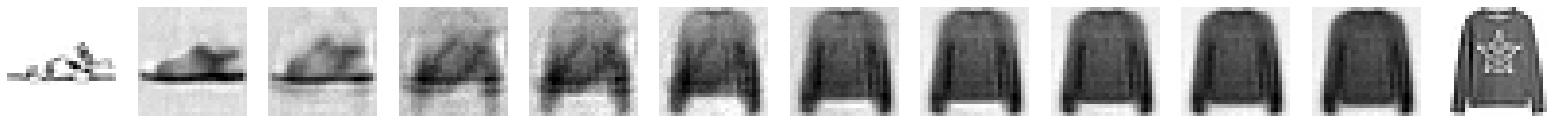

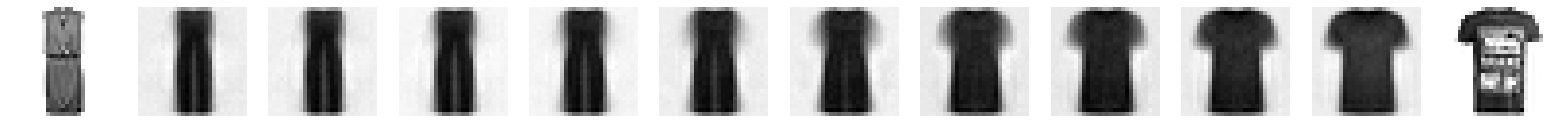

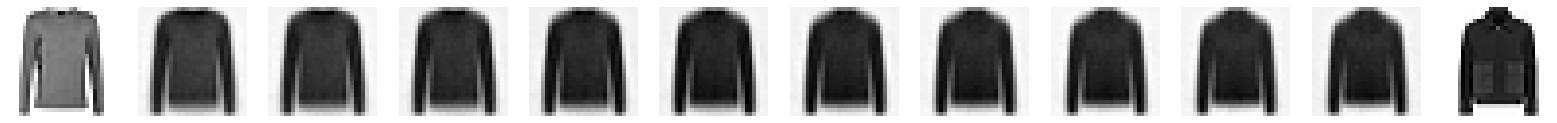

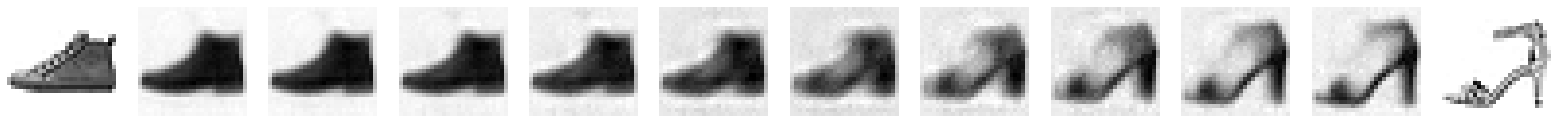

In [ ]:
def plot_interpolations(model,name, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)
    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]
        model.eval()
        images = list()
        ################################ P16 #####################################
        # give your images(img1,img2) to model and get latent value for each     #
        # images.call them z1 and z2. then in z dimension space split the line   #
        # distance between z1 and z2,into n_cols and start to move from z1 to z2 #
        # and find n_cols point between z1 and z2 (in z_dim space). then use     #
        # decoder for new points in z_space and get new image for each point.    #
        # first append img1 to images list then append all new image that        #
        # decoders produced and then append img2 at the end of list.             #
        ##########################################################################
        dropped_out = model.dropout(img1)
        h = model.encoder(dropped_out)
        if name == 'vae':
            mu =  model.mu_layer(h)
            logvar = model.logvar_layer(h)
            z1 = model.reparameterize(mu, logvar)
        else:
            z1 = model.z_layer(h)

        dropped_out = model.dropout(img2)
        h = model.encoder(dropped_out)
        if name == 'vae':
            mu =  model.mu_layer(h)
            logvar = model.logvar_layer(h)
            z2 = model.reparameterize(mu, logvar)
        else:
            z2 = model.z_layer(h)


        dist = (z2 - z1)/n_cols 
        images.append(img1)
        for i in range(n_cols):
            img = model.decoder(z1+dist*i).cpu().detach()
            images.append(img)
        images.append(img2)
        ################################ end #####################################
        images = torch.stack(images)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(images)
    print('---\n')
plot_interpolations(ae,'ae', 3)
plot_interpolations(vae,'vae', 3)